In [11]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
import matplotlib.pyplot as plt
import torch.optim as optim
import warnings
import numpy as np
from torch.nn import Parameter
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from PIL import Image

warnings.filterwarnings('ignore') 
device = torch.device("cuda:0")
device

device(type='cuda', index=0)

In [12]:
class BIRADSDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.samples = []
        
        for label in self.classes:
            patient_dirs = os.listdir(os.path.join(root_dir, label))
            for patient_id in patient_dirs:
                patient_dir = os.path.join(root_dir, label, patient_id)
                images = os.listdir(patient_dir)
                if len(images) == 2:  
                    image_paths = [os.path.join(patient_dir, img) for img in images]
                    self.samples.append((image_paths, label))
    
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_paths, label = self.samples[idx]
        images = [Image.open(img_path).convert('RGB') for img_path in image_paths]
        
        if self.transform:
            images = [self.transform(img) for img in images]
 
        label = 0 if 'BIRADS12' in label else 1 
        
        return (images[0], images[1]), label

In [ ]:
data_dir = "BIRADS12_45DatasetwTest"
train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'valid')
test_dir = os.path.join(data_dir, 'test')
# Transforms
train_transforms = transforms.Compose([
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.2),
    transforms.Resize((520, 520)),
    transforms.RandomCrop((500, 500)),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
valid_transforms = transforms.Compose([
    transforms.Resize((500, 500)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
test_transforms = transforms.Compose([
    transforms.Resize((500, 500)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = BIRADSDataset(train_dir, transform=train_transforms)
valid_dataset = BIRADSDataset(valid_dir, transform=valid_transforms)
test_dataset = BIRADSDataset(test_dir, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [14]:
train_dataset.classes

['BIRADS12', 'BIRADS45']

In [15]:
print(len(train_loader))
print(len(valid_loader))
print(len(test_loader))

293
38
10


In [16]:
valid_dataset.classes

['BIRADS12', 'BIRADS45']

In [17]:
test_dataset.classes

['BIRADS12', 'BIRADS45']

In [19]:
class WeightedDoubleClassifier(nn.Module):
    def __init__(self, in_features, out_features, n=2):
        super(WeightedDoubleClassifier, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.n = n
        self.base = 1000.0
        self.iter = 0
        self.weight = Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)
    
    def forward(self, input, label):
        self.iter += 1

        cos_theta = F.linear(F.normalize(input), F.normalize(self.weight))
        cos_theta = cos_theta.clamp(-1, 1)
        theta = cos_theta.data.acos()

        phi1 = torch.cat([cos_theta[:,0].view(-1,1)*self.n, cos_theta[:,1].view(-1,1)],dim=1)
        phi2 = torch.cat([cos_theta[:,0].view(-1,1), cos_theta[:,1].view(-1,1)*self.n,],dim=1)
        output1 =  phi1 * torch.norm(input, 2, 1).view(-1, 1)
        output2 = phi2 * torch.norm(input, 2, 1).view(-1, 1)
        output_std = cos_theta * torch.norm(input, 2, 1).view(-1, 1)
        return output1, output2, output_std

### EfficientNetb0 and EfficientNetb3 with WDC classifier head

In [20]:
class Effnetb0(nn.Module): 
    def __init__(self, model):
        super(Effnetb0, self).__init__()
        self.effnet_layer = nn.Sequential(*list(model.children())[:-1])
        self.avp_pooling = nn.AdaptiveAvgPool2d((1, 1)) 
        self.linear_layer1 = nn.Linear(2560, 1024) 
        self.linear_layer2 = WeightedDoubleClassifier(1024, 2)
        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()
        
    def forward(self, img1, img2, label):
        
        x1 = self.effnet_layer(img1)
        x1 = self.avp_pooling(x1).view(x1.size()[0], -1)

        x2 = self.effnet_layer(img2)
        x2 = self.avp_pooling(x2).view(x2.size()[0], -1)

        x = torch.cat((x1, x2), dim=1)
        x = self.dropout(x)
        x = self.relu(self.linear_layer1(x))
        x = self.dropout(x)
        x1, x2, x_std = self.linear_layer2(x, label)

        return x1, x2, x_std
    
class Effnetb3(nn.Module): 
    def __init__(self, model):
        super(Effnetb3, self).__init__()
        self.effnet_layer = nn.Sequential(*list(model.children())[:-1])
        self.avp_pooling = nn.AdaptiveAvgPool2d((1, 1)) 
        self.linear_layer1 = nn.Linear(3072, 1024) 
        self.linear_layer2 = WeightedDoubleClassifier(1024, 2)
        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()
        
    def forward(self, img1, img2, label):
        
        x1 = self.effnet_layer(img1)
        x1 = self.avp_pooling(x1).view(x1.size()[0], -1)

        x2 = self.effnet_layer(img2)
        x2 = self.avp_pooling(x2).view(x2.size()[0], -1)

        x = torch.cat((x1, x2), dim=1)
        x = self.dropout(x)
        x = self.relu(self.linear_layer1(x))
        x = self.dropout(x)
        x1, x2, x_std = self.linear_layer2(x, label)

        return x1, x2, x_std

def weight_loss(output1, output2, label):
    loss1 = 0.
    loss2 = 0.
    pred1 = output1.argmax(dim=1, keepdim = True)
    pred2 = output2.argmax(dim=1, keepdim = True)
    for i in range(len(pred1)): 
        if pred1[i] == pred2[i]:
            loss1 += -label[i] * torch.log_softmax(output1[i], -1)[1]-(1-label[i]) * torch.log_softmax(output1[i], -1)[0]  #+ 1e-10
            loss2 += -label[i] * torch.log_softmax(output2[i], -1)[1]-(1-label[i]) * torch.log_softmax(output2[i], -1)[0]
        else:
            alpha_weight = 2. - torch.abs(torch.softmax(output1[i], -1)[1]-torch.softmax(output2[i], -1)[1])
            if label[i] == pred2[i]:
                loss1 += (-label[i] * torch.log_softmax(output1[i], -1)[1]-(1-label[i]) * torch.log_softmax(output1[i], -1)[0]) * alpha_weight
            else:
                loss2 += (-label[i] * torch.log_softmax(output2[i], -1)[1]-(1-label[i]) * torch.log_softmax(output2[i], -1)[0]) * alpha_weight 
    return loss1/len(pred1), loss2/len(pred2)

In [ ]:
base_model = models.efficientnet_b0(pretrained=True)
cnn = Effnetb0(base_model).to(device)
model = cnn
num_epochs = 10 
learning_rate = 0.0001
best_val_loss = float('inf')  
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
best_model_path = "birads12-45_efficientnet_b0_wdcc.pth"

In [12]:
model

CNN(
  (effnet_layer): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_activation): 

In [13]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for (img1, img2), labels in tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=False):
        img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
        optimizer.zero_grad()
        output1, output2, _ = model(img1, img2, labels)
        loss1, loss2 = weight_loss(output1, output2, labels)
        loss = loss1 + loss2
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f"\nEpoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")
    
    # Validation loop
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        correct1 = 0
        correct2 = 0
        total = 0
        
        for (img1, img2), labels in tqdm(valid_loader, desc="Validation", leave=False):
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
            output1, output2, _ = model(img1, img2, labels)
            loss1, loss2 = weight_loss(output1, output2, labels)
            val_loss += (loss1 + loss2).item()
            pred1 = output1.argmax(dim=1)
            pred2 = output2.argmax(dim=1)
            correct1 += (pred1 == labels).sum().item()
            correct2 += (pred2 == labels).sum().item()
            total += labels.size(0)
            
        avg_val_loss = val_loss / len(valid_loader)
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), best_model_path)
            print("Best model saved!")
        
        print(f"Validation Loss: {val_loss/len(valid_loader):.4f}, "
              f"Accuracy1: {correct1/total*100:.2f}%, Accuracy2: {correct2/total*100:.2f}%")


Epoch [1/10], Loss: 1.2560


Best model saved!
Validation Loss: 0.9766, Accuracy1: 79.00%, Accuracy2: 78.67%



Epoch [2/10], Loss: 0.9151


Best model saved!
Validation Loss: 0.7589, Accuracy1: 83.33%, Accuracy2: 83.00%



Epoch [3/10], Loss: 0.7846


Best model saved!
Validation Loss: 0.6694, Accuracy1: 85.67%, Accuracy2: 86.00%



Epoch [4/10], Loss: 0.6521


Validation Loss: 0.6969, Accuracy1: 88.00%, Accuracy2: 88.33%



Epoch [5/10], Loss: 0.6201


Best model saved!
Validation Loss: 0.5758, Accuracy1: 89.33%, Accuracy2: 89.33%



Epoch [6/10], Loss: 0.5694


Validation Loss: 0.6214, Accuracy1: 90.00%, Accuracy2: 90.33%



Epoch [7/10], Loss: 0.4934


Validation Loss: 0.7641, Accuracy1: 87.00%, Accuracy2: 86.67%



Epoch [8/10], Loss: 0.4784


Best model saved!
Validation Loss: 0.5677, Accuracy1: 90.33%, Accuracy2: 90.33%



Epoch [9/10], Loss: 0.4638


Best model saved!
Validation Loss: 0.5513, Accuracy1: 90.67%, Accuracy2: 90.67%



Epoch [10/10], Loss: 0.3964


Validation Loss: 0.6479, Accuracy1: 89.67%, Accuracy2: 90.00%



Confusion Matrix for output1:


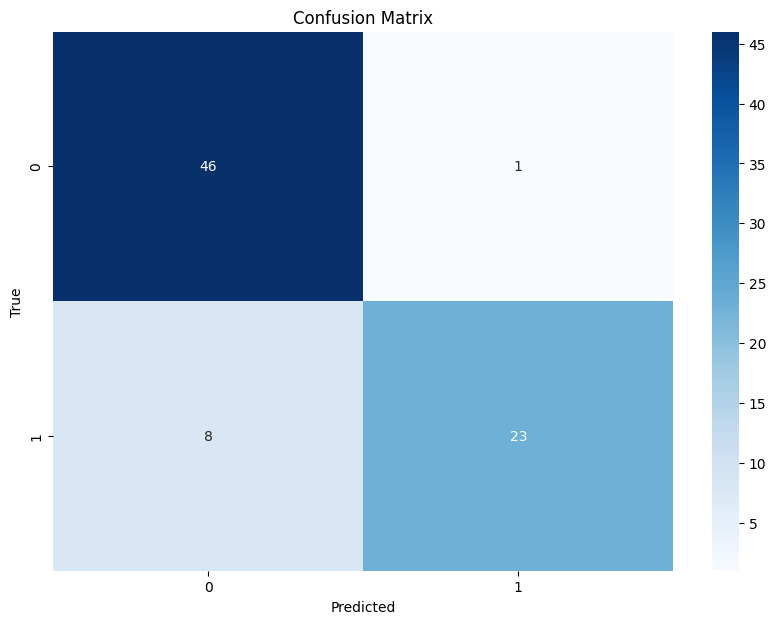


Classification Report for output1:
              precision    recall  f1-score   support

           0       0.85      0.98      0.91        47
           1       0.96      0.74      0.84        31

    accuracy                           0.88        78
   macro avg       0.91      0.86      0.87        78
weighted avg       0.89      0.88      0.88        78


Confusion Matrix for output2:


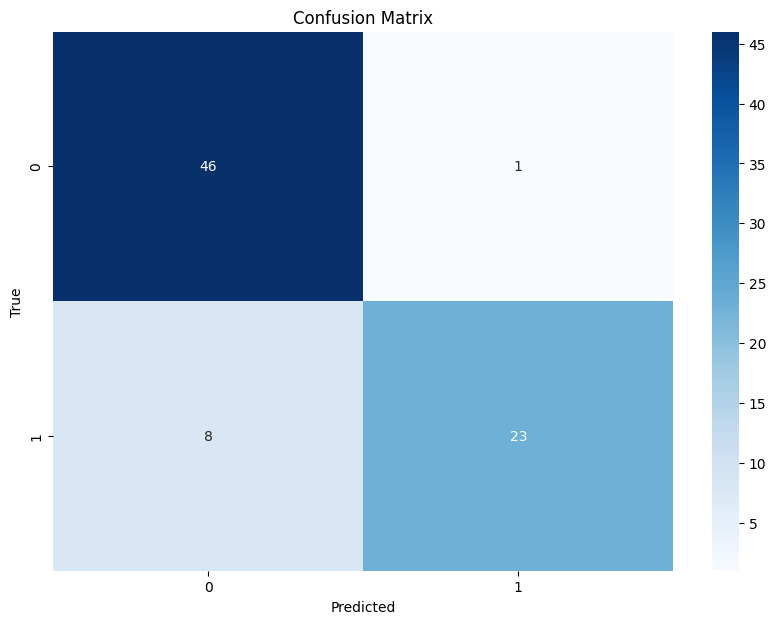


Classification Report for output2:
              precision    recall  f1-score   support

           0       0.85      0.98      0.91        47
           1       0.96      0.74      0.84        31

    accuracy                           0.88        78
   macro avg       0.91      0.86      0.87        78
weighted avg       0.89      0.88      0.88        78


Class-wise Accuracy for output1: 88.46%

Class-wise Accuracy for output2: 88.46%


In [ ]:
#state_dict = torch.load('birads12-45_efficientnet_b0_wdcc.pth')
#model.load_state_dict(state_dict)

def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

model.eval()
all_labels = []
all_preds1 = []
all_preds2 = []

with torch.no_grad():
    for (img1, img2), labels in tqdm(test_loader, desc="Testing", leave=False):
        img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
        output1, output2, _ = model(img1, img2, labels)
        pred1 = output1.argmax(dim=1)
        pred2 = output2.argmax(dim=1)
        
        all_labels.extend(labels.cpu().numpy())
        all_preds1.extend(pred1.cpu().numpy())
        all_preds2.extend(pred2.cpu().numpy())


cm1 = confusion_matrix(all_labels, all_preds1)
print("\nConfusion Matrix for output1:")
plot_confusion_matrix(cm1, classes=[0, 1])  

print("\nClassification Report for output1:")
print(classification_report(all_labels, all_preds1, target_names=[str(i) for i in range(len(cm1))]))
cm2 = confusion_matrix(all_labels, all_preds2)
print("\nConfusion Matrix for output2:")
plot_confusion_matrix(cm2, classes=[0, 1])  

print("\nClassification Report for output2:")
print(classification_report(all_labels, all_preds2, target_names=[str(i) for i in range(len(cm2))]))

accuracy1 = accuracy_score(all_labels, all_preds1)
print(f"\nClass-wise Accuracy for output1: {accuracy1*100:.2f}%")
accuracy2 = accuracy_score(all_labels, all_preds2)
print(f"\nClass-wise Accuracy for output2: {accuracy2*100:.2f}%")

In [ ]:
base_model = models.efficientnet_b3(pretrained=True)
effnetb3 = Effnetb3(base_model).to(device)
model = effnetb3
num_epochs = 10 
learning_rate = 0.0001
best_val_loss = float('inf')  
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
best_model_path = "birads12-45_efficientnet_b3_wdcc.pth"
model

Effnetb3(
  (effnet_layer): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
              (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_activa

In [22]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for (img1, img2), labels in tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=False):
        img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
        optimizer.zero_grad()
        output1, output2, _ = model(img1, img2, labels)
        loss1, loss2 = weight_loss(output1, output2, labels)
        loss = loss1 + loss2
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f"\nEpoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")
    
    # Validation loop
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        correct1 = 0
        correct2 = 0
        total = 0
        
        for (img1, img2), labels in tqdm(valid_loader, desc="Validation", leave=False):
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
            output1, output2, _ = model(img1, img2, labels)
            loss1, loss2 = weight_loss(output1, output2, labels)
            val_loss += (loss1 + loss2).item()
            pred1 = output1.argmax(dim=1)
            pred2 = output2.argmax(dim=1)
            correct1 += (pred1 == labels).sum().item()
            correct2 += (pred2 == labels).sum().item()
            total += labels.size(0)
            
        avg_val_loss = val_loss / len(valid_loader)
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), best_model_path)
            print("Best model saved!")
        
        print(f"Validation Loss: {val_loss/len(valid_loader):.4f}, "
              f"Accuracy1: {correct1/total*100:.2f}%, Accuracy2: {correct2/total*100:.2f}%")


Epoch [1/10], Loss: 1.1250


Best model saved!
Validation Loss: 0.9733, Accuracy1: 77.33%, Accuracy2: 77.33%



Epoch [2/10], Loss: 0.8184


Best model saved!
Validation Loss: 0.6714, Accuracy1: 84.67%, Accuracy2: 85.00%



Epoch [3/10], Loss: 0.7209


Best model saved!
Validation Loss: 0.6482, Accuracy1: 87.00%, Accuracy2: 87.00%



Epoch [4/10], Loss: 0.5635


Best model saved!
Validation Loss: 0.5753, Accuracy1: 89.33%, Accuracy2: 89.33%



Epoch [5/10], Loss: 0.5396


Best model saved!
Validation Loss: 0.5147, Accuracy1: 90.00%, Accuracy2: 90.00%



Epoch [6/10], Loss: 0.4587


Validation Loss: 0.5430, Accuracy1: 90.00%, Accuracy2: 89.67%



Epoch [7/10], Loss: 0.4727


Validation Loss: 0.5641, Accuracy1: 88.33%, Accuracy2: 88.33%



Epoch [8/10], Loss: 0.3609


Validation Loss: 0.7590, Accuracy1: 87.33%, Accuracy2: 87.33%



Epoch [9/10], Loss: 0.3394


Validation Loss: 0.6362, Accuracy1: 88.33%, Accuracy2: 88.33%



Epoch [10/10], Loss: 0.3266


Validation Loss: 0.6259, Accuracy1: 90.00%, Accuracy2: 90.00%



Confusion Matrix for output1:


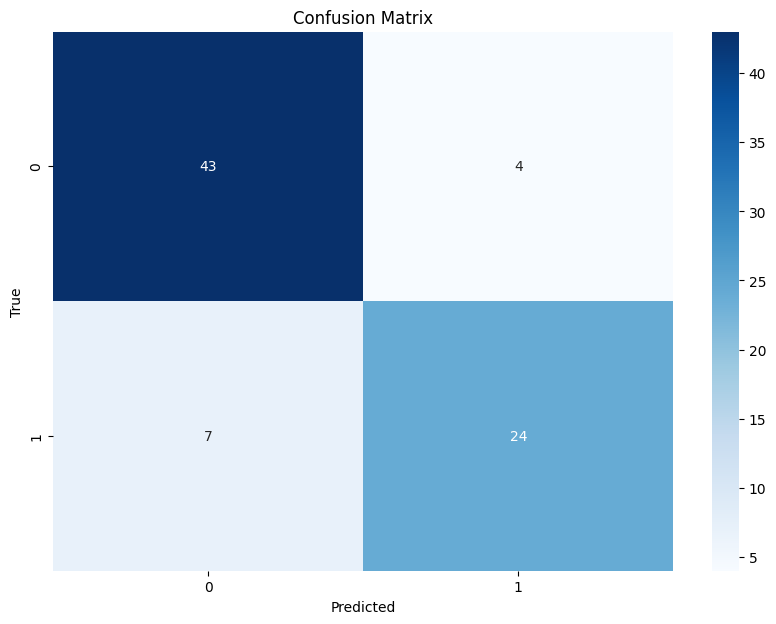


Classification Report for output1:
              precision    recall  f1-score   support

           0       0.86      0.91      0.89        47
           1       0.86      0.77      0.81        31

    accuracy                           0.86        78
   macro avg       0.86      0.84      0.85        78
weighted avg       0.86      0.86      0.86        78


Confusion Matrix for output2:


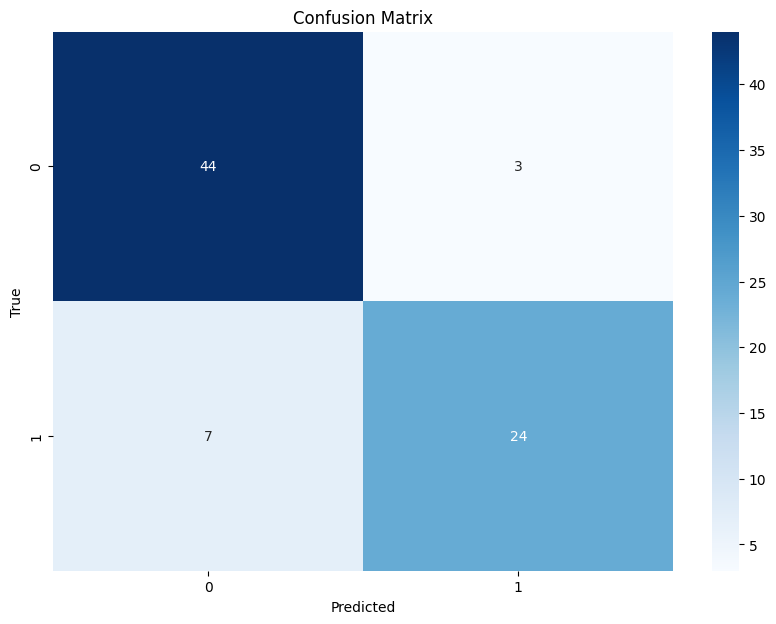


Classification Report for output2:
              precision    recall  f1-score   support

           0       0.86      0.94      0.90        47
           1       0.89      0.77      0.83        31

    accuracy                           0.87        78
   macro avg       0.88      0.86      0.86        78
weighted avg       0.87      0.87      0.87        78


Class-wise Accuracy for output1: 85.90%

Class-wise Accuracy for output2: 87.18%


In [24]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()
    
model.eval()
all_labels = []
all_preds1 = []
all_preds2 = []

with torch.no_grad():
    for (img1, img2), labels in tqdm(test_loader, desc="Testing", leave=False):
        img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
        output1, output2, _ = model(img1, img2, labels)
        pred1 = output1.argmax(dim=1)
        pred2 = output2.argmax(dim=1)
        
        all_labels.extend(labels.cpu().numpy())
        all_preds1.extend(pred1.cpu().numpy())
        all_preds2.extend(pred2.cpu().numpy())


cm1 = confusion_matrix(all_labels, all_preds1)
print("\nConfusion Matrix for output1:")
plot_confusion_matrix(cm1, classes=[0, 1])  

print("\nClassification Report for output1:")
print(classification_report(all_labels, all_preds1, target_names=[str(i) for i in range(len(cm1))]))
cm2 = confusion_matrix(all_labels, all_preds2)
print("\nConfusion Matrix for output2:")
plot_confusion_matrix(cm2, classes=[0, 1])  

print("\nClassification Report for output2:")
print(classification_report(all_labels, all_preds2, target_names=[str(i) for i in range(len(cm2))]))

accuracy1 = accuracy_score(all_labels, all_preds1)
print(f"\nClass-wise Accuracy for output1: {accuracy1*100:.2f}%")
accuracy2 = accuracy_score(all_labels, all_preds2)
print(f"\nClass-wise Accuracy for output2: {accuracy2*100:.2f}%")

### EfficientNetb0 and EfficientNetb3 with normal classifier head

In [25]:
class Effnetb0_2(nn.Module): 
    def __init__(self, model):
        super(Effnetb0_2, self).__init__()
        self.effnet_layer = nn.Sequential(*list(model.children())[:-1])
        self.avp_pooling = nn.AdaptiveAvgPool2d((1, 1)) 
        self.linear_layer1 = nn.Linear(2560, 1024) 
        self.linear_layer2 = nn.Linear(1024, 2)
        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()
        
    def forward(self, img1, img2):
        # first image
        x1 = self.effnet_layer(img1)
        x1 = self.avp_pooling(x1).view(x1.size()[0], -1)

        # second image
        x2 = self.effnet_layer(img2)
        x2 = self.avp_pooling(x2).view(x2.size()[0], -1)

        x = torch.cat((x1, x2), dim=1)
        x = self.dropout(x)
        x = self.relu(self.linear_layer1(x))
        x = self.dropout(x)
        x = self.relu(self.linear_layer2(x))

        return x
    
class Effnetb3_2(nn.Module): 
    def __init__(self, model):
        super(Effnetb3_2, self).__init__()
        self.effnet_layer = nn.Sequential(*list(model.children())[:-1])
        self.avp_pooling = nn.AdaptiveAvgPool2d((1, 1)) 
        self.linear_layer1 = nn.Linear(3072, 1024) 
        self.linear_layer2 = nn.Linear(1024, 2)
        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()
        
    def forward(self, img1, img2):
        # first image
        x1 = self.effnet_layer(img1)
        x1 = self.avp_pooling(x1).view(x1.size()[0], -1)

        # second image
        x2 = self.effnet_layer(img2)
        x2 = self.avp_pooling(x2).view(x2.size()[0], -1)

        x = torch.cat((x1, x2), dim=1)
        x = self.dropout(x)
        x = self.relu(self.linear_layer1(x))
        x = self.dropout(x)
        x = self.relu(self.linear_layer2(x))

        return x

In [ ]:
base_model = models.efficientnet_b0(pretrained=True) 
cnn2 = Effnetb0_2(base_model).to(device)
model2 = cnn2
num_epochs = 10 
learning_rate = 0.0001
best_val_loss = float('inf')  
optimizer = optim.Adam(model2.parameters(), lr=learning_rate)
best_model_path = "birads12-45_efficientnet_b0_normal.pth"
criterion = torch.nn.CrossEntropyLoss()

In [26]:
for epoch in range(num_epochs):
    model2.train()
    running_loss = 0.0
    
    for (img1, img2), labels in tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]"):
        img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model2(img1, img2)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}")
    
    # Validation loop
    model2.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for (img1, img2), labels in tqdm(valid_loader, desc="Validation"):
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
            outputs = model2(img1, img2)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss /= len(valid_loader)
    accuracy = 100 * correct / total
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.2f}%")
    
    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model2.state_dict(), best_model_path)
        print("Best model saved!")

print("Training finished!")

NameError: name 'model2' is not defined

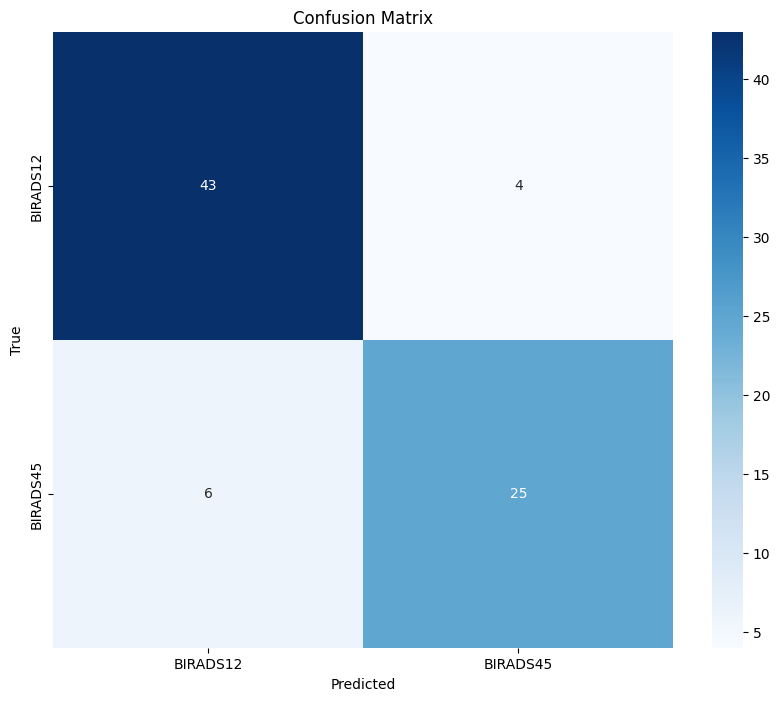

              precision    recall  f1-score   support

    BIRADS12       0.88      0.91      0.90        47
    BIRADS45       0.86      0.81      0.83        31

    accuracy                           0.87        78
   macro avg       0.87      0.86      0.86        78
weighted avg       0.87      0.87      0.87        78

Overall Accuracy: 0.8718
Accuracy for class BIRADS12: 0.9149
Accuracy for class BIRADS45: 0.8065


: 

In [ ]:
y_true = []
y_pred = []

#state_dict = torch.load('birads12-45_efficientnet_b0_normal.pth')
#model2.load_state_dict(state_dict)

model2.eval()
class_names = ['BIRADS12', 'BIRADS45']
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

with torch.no_grad():
    for inputs, labels in test_loader:

        inputs = [img.to(device) for img in inputs]
        labels = labels.to(device)
        
        outputs = model2(inputs[0], inputs[1])
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


print(classification_report(y_true, y_pred, target_names=class_names))
accuracy = np.sum(np.array(y_true) == np.array(y_pred)) / len(y_true)
print(f'Overall Accuracy: {accuracy:.4f}')
class_accuracy = cm.diagonal() / cm.sum(axis=1)
for i, acc in enumerate(class_accuracy):
    print(f'Accuracy for class {class_names[i]}: {acc:.4f}')

In [ ]:
base_model = models.efficientnet_b3(pretrained=True)
effnet_b3_2 = Effnetb3_2(base_model).to(device)
model2 = effnet_b3_2
num_epochs = 10 
learning_rate = 0.0001
best_val_loss = float('inf')  
optimizer = optim.Adam(model2.parameters(), lr=learning_rate)
best_model_path = "birads12-45_efficientnet_b3_normal.pth"
criterion = torch.nn.CrossEntropyLoss()

In [28]:
for epoch in range(num_epochs):
    model2.train()
    running_loss = 0.0
    
    for (img1, img2), labels in tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]"):
        img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model2(img1, img2)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}")
    
    # Validation loop
    model2.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for (img1, img2), labels in tqdm(valid_loader, desc="Validation"):
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
            outputs = model2(img1, img2)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss /= len(valid_loader)
    accuracy = 100 * correct / total
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.2f}%")
    
    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model2.state_dict(), best_model_path)
        print("Best model saved!")

print("Training finished!")

Epoch [1/10]: 100%|██████████| 293/293 [06:36<00:00,  1.35s/it]


Epoch [1/10], Train Loss: 0.5610


Validation: 100%|██████████| 38/38 [00:18<00:00,  2.03it/s]


Validation Loss: 0.5074, Accuracy: 81.67%
Best model saved!


Epoch [2/10]: 100%|██████████| 293/293 [06:37<00:00,  1.36s/it]


Epoch [2/10], Train Loss: 0.4071


Validation: 100%|██████████| 38/38 [00:19<00:00,  1.97it/s]


Validation Loss: 0.3062, Accuracy: 88.67%
Best model saved!


Epoch [3/10]: 100%|██████████| 293/293 [06:48<00:00,  1.39s/it]


Epoch [3/10], Train Loss: 0.3504


Validation: 100%|██████████| 38/38 [00:19<00:00,  1.99it/s]


Validation Loss: 0.3148, Accuracy: 86.67%


Epoch [4/10]: 100%|██████████| 293/293 [06:47<00:00,  1.39s/it]


Epoch [4/10], Train Loss: 0.3158


Validation: 100%|██████████| 38/38 [00:19<00:00,  1.95it/s]


Validation Loss: 0.3280, Accuracy: 87.33%


Epoch [5/10]: 100%|██████████| 293/293 [06:48<00:00,  1.39s/it]


Epoch [5/10], Train Loss: 0.2576


Validation: 100%|██████████| 38/38 [00:19<00:00,  1.98it/s]


Validation Loss: 0.2555, Accuracy: 90.67%
Best model saved!


Epoch [6/10]: 100%|██████████| 293/293 [06:48<00:00,  1.39s/it]


Epoch [6/10], Train Loss: 0.2421


Validation: 100%|██████████| 38/38 [00:19<00:00,  1.97it/s]


Validation Loss: 0.2764, Accuracy: 90.67%


Epoch [7/10]: 100%|██████████| 293/293 [06:45<00:00,  1.38s/it]


Epoch [7/10], Train Loss: 0.2092


Validation: 100%|██████████| 38/38 [00:19<00:00,  1.98it/s]


Validation Loss: 0.2945, Accuracy: 91.00%


Epoch [8/10]: 100%|██████████| 293/293 [06:45<00:00,  1.39s/it]


Epoch [8/10], Train Loss: 0.1937


Validation: 100%|██████████| 38/38 [00:19<00:00,  1.98it/s]


Validation Loss: 0.2515, Accuracy: 89.67%
Best model saved!


Epoch [9/10]: 100%|██████████| 293/293 [06:46<00:00,  1.39s/it]


Epoch [9/10], Train Loss: 0.1705


Validation: 100%|██████████| 38/38 [00:19<00:00,  1.97it/s]


Validation Loss: 0.3396, Accuracy: 88.33%


Epoch [10/10]: 100%|██████████| 293/293 [06:45<00:00,  1.38s/it]


Epoch [10/10], Train Loss: 0.1547


Validation: 100%|██████████| 38/38 [00:19<00:00,  1.97it/s]

Validation Loss: 0.3044, Accuracy: 88.33%
Training finished!


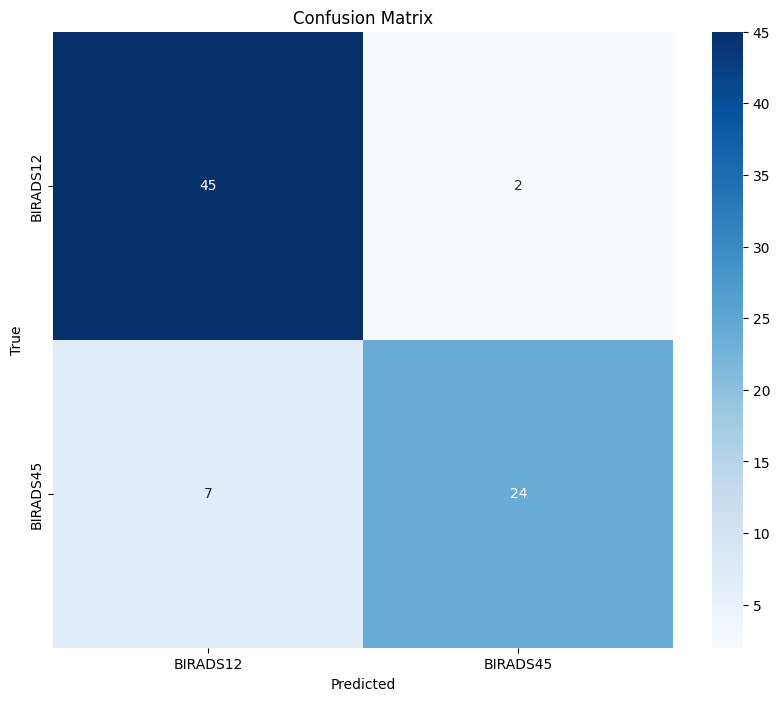

              precision    recall  f1-score   support

    BIRADS12       0.87      0.96      0.91        47
    BIRADS45       0.92      0.77      0.84        31

    accuracy                           0.88        78
   macro avg       0.89      0.87      0.88        78
weighted avg       0.89      0.88      0.88        78

Overall Accuracy: 0.8846
Accuracy for class BIRADS12: 0.9574
Accuracy for class BIRADS45: 0.7742


: 

In [ ]:
y_true = []
y_pred = []

#state_dict = torch.load('birads12-45_efficientnet_b3_normal.pth')
#model2.load_state_dict(state_dict)

model2.eval()
class_names = ['BIRADS12', 'BIRADS45']
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

with torch.no_grad():
    for inputs, labels in test_loader:

        inputs = [img.to(device) for img in inputs]
        labels = labels.to(device)
        
        outputs = model2(inputs[0], inputs[1])
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


print(classification_report(y_true, y_pred, target_names=class_names))
accuracy = np.sum(np.array(y_true) == np.array(y_pred)) / len(y_true)
print(f'Overall Accuracy: {accuracy:.4f}')
class_accuracy = cm.diagonal() / cm.sum(axis=1)
for i, acc in enumerate(class_accuracy):
    print(f'Accuracy for class {class_names[i]}: {acc:.4f}')